## Part 3 Parameter estimation techniques (Frequentist)

Other tutorials
* See also [Hannu's tutorial](https://github.com/hpparvi/exo_tutorials/blob/master/01_broadband_parameter_estimation.ipynb)
* Bayesian and Frequentist Statistics Explained [J. van der Plas blog](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)
* Data Analysis Recipes: Fitting a model to data ([Hogg et al.](https://arxiv.org/abs/1008.4686))

In [1]:
#check python version
!python --version

Python 3.6.2 :: Continuum Analytics, Inc.


In [2]:
#check environment
import os
os.environ['CONDA_DEFAULT_ENV']

'py3'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

#styling
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize=18

## import data

In [4]:
from glob import glob

datadir = '.'
path    = os.path.join(datadir,'TRAPPIST-1_rad13_temp2.csv')
file_list = glob(path)
file_list = sorted(file_list)
file_list

['./TRAPPIST-1_rad13_temp2.csv']

In [5]:
df = pd.read_csv("TRAPPIST-1_rad13_temp2.csv", delimiter=',', parse_dates=True)

In [6]:
df = df.drop('Unnamed: 0',axis=1)

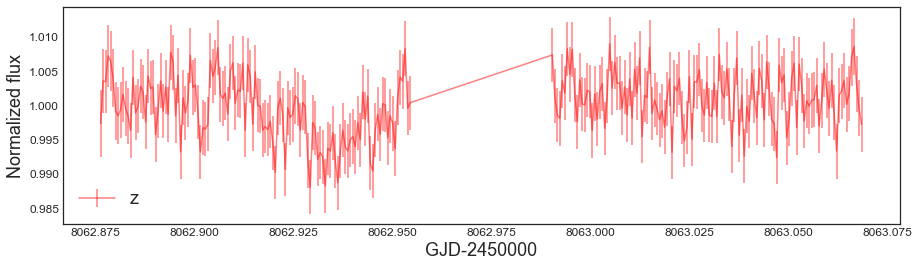

In [7]:
import matplotlib.pyplot as pl
%matplotlib inline

fig,ax = pl.subplots(1,1,figsize=(15,4))
    
time = df["GJD-2450000"]
flux = df["flux"]
err  = df["err"]
    
ax.errorbar(time, flux, yerr=err, label="z", color="r", alpha=0.5)
ax.set_ylabel('Normalized flux', fontsize=fontsize)

pl.legend(loc='lower left', fontsize=fontsize)
pl.xlabel('GJD-2450000', fontsize=fontsize)

## setting-up the transit model 

```
* t:     time
* k:     Rp/Rs: planet-star radius ratio (=k^2: transit depth)
* u1,u2: limb-darkening coefficients
* tc:    transit center
* P:     orbital period
* a_s:   a/Rs: scaled semi-major axis
* i:     inclination
* e:     eccentricity
* w:     argument of periastron
* c:     contamination factor
```

Convention:
* _P  : published value
* P_  : derived value
* P_0 : initial guess

In [8]:
def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

def u_to_q(u1, u2):
    '''
    convert limb-darkening coefficients
    from u to q
    
    see Eq. 15 & 16 in Kipping 2013
    '''
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2

def q_to_u(q1, q2):
    '''
    convert limb-darkening coefficients
    from q to u
    
    see Eq. 17 & 18 in Kipping 2013
    '''
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

from pytransit import MandelAgol

def transit_model_q(parameters, period, time, model=MandelAgol()):
    '''
    Compute flux using the Mandel-Agol model:
    
    \frac{I(\mu)}{I(1)} = 1 − u_1(1 − \mu) − u_2(1 − \mu)^2
    
    `parameters` must be a list containing:
    * k  : Rp/Rs: planet-star radius ratio
    * q1 : limb-darkening coefficient (for the linear term)
    * q2 : limb-darkening coefficient (for the quadratice term)
    * tc : transit center
    * a_s: a/Rs: scaled semi-major axis
    * b  : impact parameter
    '''
    k,q1,q2,tc,a,b = parameters
    
    #compute inclination
    inc   = np.arccos(b/a)
    #convert q to u
    u1,u2 = q_to_u(q1, q2)
    #evaluate the model
    m = model.evaluate(time, k, (u1,u2), tc, period, a, inc)
    
    return m

In [9]:
import numpy as np

#values come from S.Wang et al.(2017) 
_tc  = 8062.9449 
_P   = 6.099570 #pm 0.000091 (days)
_a   = 0.02818 #semimajor axis (AU)
_e   = 0.007 #pm 0.003
_Rp  = 0.918 #pm0.039 (R_earth)

#from M.Gillon et al.(2017)
_Rs  = 0.117 #pm 0.0036 (R_sun)
_b   = 0.12 #+0.11/-0.09
_inc = np.deg2rad(89.86) #+0.10/-0.12

from astropy import units as u
_Rp = 0.918
_Rs = 0.117*u.Rsun.to(u.Rearth)
k_ = _Rp/_Rs

_a = 0.02818
_Rs = 0.117*u.Rsun.to(u.au)
a_s_= _a/_Rs

tc_0      = 8062.930

In [10]:
import limbdark as ld

teff, uteff = 2559,  50 #from M.Gillon(2017)
logg, ulogg = 4.39, 0.03 #from Exoplanets Data Explorer
feh, ufeh   = 0.04,  0.08 #from M.Gillon(2017)

u1_,u1err, u2_,u2err = ld.claret('z*', teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4))

print('z-band: u1={}+-{:.3f}, u2={}+={:.3f}'.format(u1_,u1err, u2_,u2err))

ldc_list     = []
ldc_err_list = []

ldc = ld.claret("z*", teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4))
    
#save in list
#u1,u2
ldc_list.append([ldc[0],ldc[2]]) #take first and third element of ldc 
#uncertainties
ldc_err_list.append([ldc[1],ldc[3]]) #take second and fourth element of ldc

z-band: u1=0.3733+-0.076, u2=0.5481+=0.131


In [11]:
u_to_q(ldc_list[0][0],ldc_list[0][1])

(0.84897796000000003, 0.20257217278055134)

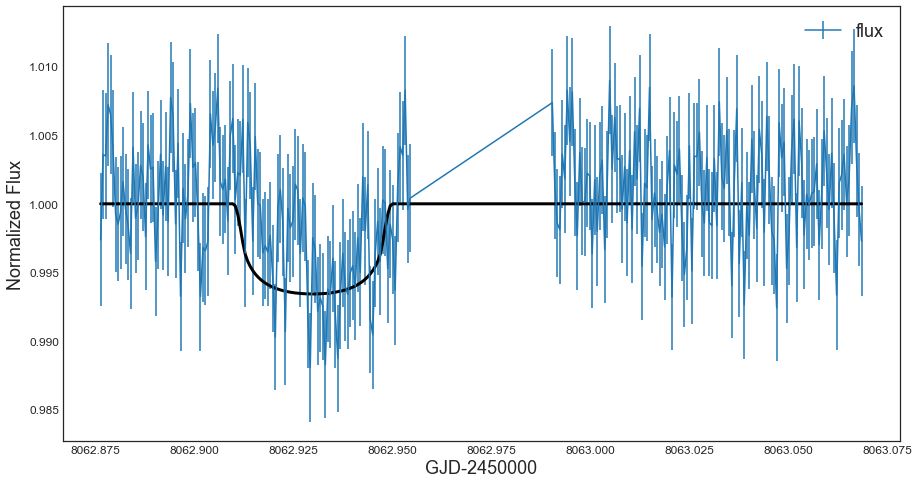

In [12]:
fig,ax = pl.subplots(1,1,figsize=(15,8))

transit_params_list = []
    
flux = df["flux"]
time = df["GJD-2450000"]
err  = df["err"]
pl.errorbar(time, flux, yerr=err) 
    
#compute q from u found in limbdark
q1_,q2_ = u_to_q(u1_,u2_)
    
#compute flux
transit_params  = [k_,q1_,q2_,tc_0,a_s_,_b]
flux_model      = transit_model_q(transit_params, _P, time)
    
#plot transit model    
ax.plot(time, flux_model, 'k-', lw=3)
ax.legend(fontsize=fontsize)
transit_params_list.append(transit_params)


ax.set_ylabel('Normalized Flux', fontsize=fontsize)
ax.set_xlabel('GJD-2450000', fontsize=fontsize)

## Maximum Likelihood Estimation (MLE)

Goal: Maximimize the Likelihood Probability

See also [John's tutorial](http://nbviewer.jupyter.org/github/john-livingston/python-seminar/blob/master/notebooks/optimization-quickie.ipynb) in github.

In [13]:
import scipy.optimize

scipy.optimize?

In [14]:
import scipy.optimize as op

def obj(theta, p, t, f, err):
    '''
    objective function: chi-squared
    '''
    m = transit_model_q(theta, p, t)
    
    return np.sum(((m-f)/err)**2)

In [15]:
params = [k_, q1_, q2_, tc_0, a_s_, _b]
dof = len(time) - len(params)
chisq = obj(params, _P, time, flux, err)
chisq/dof

1.0658117970850316

In [16]:
#z-band
params = [k_, q1_, q2_, tc_0, a_s_, _b]

time    = df["GJD-2450000"]
flux    = df['flux']

result = op.minimize(obj, params, args=(_P, time, flux, err), method='nelder-mead')

In [17]:
result.success

True

In [18]:
dof = len(time) - len(params)
result.fun / dof

0.98332369377458162

In [26]:
ldc_z   = ldc_list[0]
u_to_q(ldc_z[0],ldc_z[1])

(0.84897796000000003, 0.20257217278055134)

In [29]:
params_names='k,q1,q2,tc,a_s,b'.split(',')

#compare params for z(before)
ldc_z   = ldc_list[0]
q1_,q2_ = u_to_q(ldc_z[0], ldc_z[1])

#after optimization
after = [k_,q1_,q2_,tc_0,a_s_,_b]

print('\tbefore\tafter optimization')
for names,before,after in zip(params_names,result.x,after):
    print('{}:\t{:.9f}\t{:.9f}'.format(names,before,after))

	before	after optimization
k:	0.071932213	0.071932663
q1:	0.848977929	0.848977960
q2:	0.202572299	0.202572173
tc:	8062.933970444	8062.930000000
a_s:	54.380985083	51.791505528
b:	0.120000517	0.120000000


Now let's do MLE optimization and plot for each band. We can quantitavely see how good the fit by computing the root-mean-square (rms) error of the residuals before and after the fit.

In [30]:
def rms(flux,flux_model):
    residual = flux-flux_model
    return np.sqrt(np.mean((residual)**2))

rms before: 0.0040
rms after: 0.0039


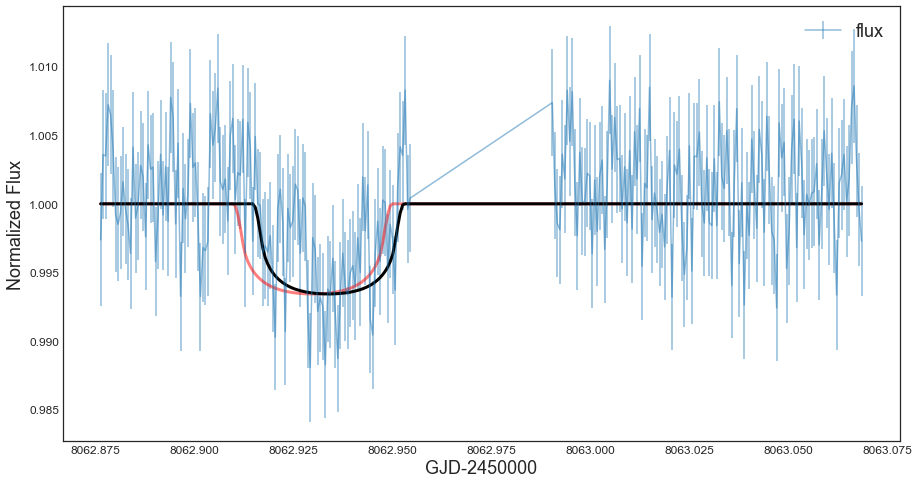

In [31]:
fig,ax = pl.subplots(1,1,figsize=(15,8))

transit_params_list = []

flux = df["flux"]
time = df["GJD-2450000"]
err  = df["err"]
    
pl.errorbar(time, flux, yerr=err, alpha=0.5) 
    
#compute q from u found in limbdark
ldc_z   = ldc_list[0]
q1_,q2_ = u_to_q(ldc_z[0],ldc_z[1])

#compute flux before optimization
transit_params     = [k_,q1_,q2_,tc_0,a_s_,_b]
flux_model_before  = transit_model_q(transit_params, _P, time)
#rms before
rms_before = rms(flux,flux_model_before)
print('rms before: {:.4f}'.format(rms_before))
    
#optimize parameters
result = op.minimize(obj, transit_params,
                     args=(_P, time, flux, err), method='nelder-mead')
    
#compute flux after optimization
transit_params_after     = [k_,q1_,q2_,tc_0,a_s_,_b]
flux_model_after  = transit_model_q(result.x, _P, time)
#rms after
rms_after = rms(flux,flux_model_after)
print('rms after: {:.4f}'.format(rms_after))
    
#plot transit models
#before (faint red)
ax.plot(time, flux_model_before, 'r-', lw=3, alpha=0.5)
#after (black)
ax.plot(time, flux_model_after, 'k-', lw=3, alpha=1)
ax.legend(fontsize=fontsize)
transit_params_list.append(transit_params)

    
ax.set_ylabel('Normalized Flux', fontsize=fontsize)
ax.set_xlabel('GJD-2450000', fontsize=fontsize)

The optimized transit model (black line) fits the raw data better as shown by the lower rms errors after optimization for each band. 

![img](images/magic.gif)

`scipy.optimize` has a lot of built-in algorithms for minimization. Try to experiment with the code above by editing the line 
```
op.minimize(obj, params, args=(_P, time, flux, err), method='NAME_OF_ALGORITHM')
```
and choosing with any of the following:

* neldermead
* powell
* cg
* bfgs
* newtoncg
* lbfgsb
* tnc
* cobyla
* slsqp
* dogleg
* trustncg

# Appendix

Is uncertainty (size of error bars in the scatter plot above) a constant/changing?

NameError: name 'bands' is not defined

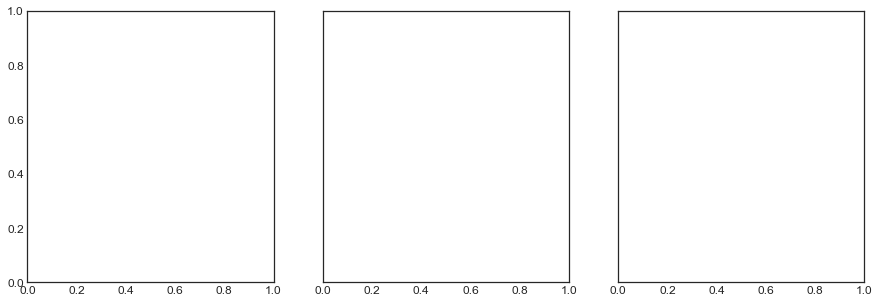

In [24]:
fig,ax = pl.subplots(1,3,figsize=(15,5), sharey=True)

n=0
for b in bands:
    df = data[b]
    
    flux    = df['flux(r=11.0)']
    err     = df['err(r=11.0)']
    airmass = df['airmass']

    ax[n].scatter(flux,err)
    ax[n].set_ylim(0.0014,0.0025)
    ax[n].set_xlabel('uncertainty (r=11.0)', fontsize=fontsize)
    ax[n].set_title('{}-band'.format(b), fontsize=fontsize)
    n=n+1

ax[0].set_ylabel('flux (r=11.0)', fontsize=fontsize)
fig.tight_layout()

The trend looks suspicious. We should expect a somewhat positive slope but the plots above shows otherwise.

In [ ]:
fig,ax = pl.subplots(1,3,figsize=(15,5), sharey=True)

n=0
for b in bands:
    df = data[b]
    
    flux    = df['flux(r=11.0)']
    err     = df['err(r=11.0)']
    airmass = df['airmass']

    ax[n].scatter(airmass,err)
    ax[n].set_ylim(0.0014,0.0025)
    ax[n].set_xlabel('airmass', fontsize=fontsize)
    ax[n].set_title('{}-band'.format(b), fontsize=fontsize)
    n=n+1
    
ax[0].set_ylabel('flux (r=11.0)', fontsize=fontsize)
fig.tight_layout()

Basically, the error of the flux measurement is proportional to the airmass (which is expected). This confirms that using the error vector in our `obj` chi-squared function for minimization is useful. 

### Optimization using Levenburg-Marquardt Algorithm 

`scipy.optimize` comes with many other optimization algorithms. Try to implment the famous Levenburg-Marquardt Algorithm by using `scipy.optimize.curve_fit`. Play with the code below and figure out how you can make it work.

* [wiki](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm)